In [29]:
import pandas as pd
from matplotlib import pyplot as plt
import talib as ta
import fredpy as fp
from pathlib import Path
import os
from dotenv import load_dotenv
load_dotenv()
fp.api_key = os.getenv("FREDPY_API_KEY")

In [30]:
PATH = Path.cwd()

In [31]:
def get_data(*args) -> dict[str, pd.Series]:
    result = {}
    for arg in args:

        data = pd.read_csv(
        PATH / f"data/crude_{arg}.csv", 
        index_col="date"
        ).squeeze()

        if arg == "production" or arg == "products_supplied":
            data.index = [date + pd.offsets.MonthEnd(1) for date in pd.to_datetime(data.index)]
        elif arg == "inventory":
            data.index = pd.to_datetime(data.index)
            data = data.resample("M").mean()
        elif arg == "imports" or arg == "exports":
            data.index = pd.to_datetime(data.index)
            data *= 7
            data = data.resample("M").sum()
        else:
            data.index = pd.to_datetime(data.index)

        result.update({arg : data})
        
    return result

In [32]:
def equalize_dict_values(series_dict: dict[str, pd.Series]) -> dict[str, pd.Series]:
    latest_start_date = max(series.index[0] for series in series_dict.values())
    return {key: series[series.index >= latest_start_date] for key, series in series_dict.items()}


In [33]:
def get_changes(dic):
    return {key : series.diff().dropna() for key, series in dic.items()}

In [34]:
data = equalize_dict_values(
    get_data(
    "imports", 
    "exports", 
    "inventory", 
    "prices", 
    "production", 
    "products_supplied", 
    "commercial_stock",
    "prices"
    )
    )

/var/folders/0g/0pyvp71x00d07s_b28p42ctc0000gn/T/ipykernel_82082/4224254447.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.index = [date + pd.offsets.MonthEnd(1) for date in pd.to_datetime(data.index)]
/var/folders/0g/0pyvp71x00d07s_b28p42ctc0000gn/T/ipykernel_82082/4224254447.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.index = [date + pd.offsets.MonthEnd(1) for date in pd.to_datetime(data.index)]


In [35]:
net_supply =  data["imports"] + data["production"] + data["inventory"].diff().dropna() - data["exports"] - data["products_supplied"]
net_supply_smoothed = ta.MA(net_supply, 10)

In [36]:
common_dates = []
for date in net_supply.index:
    if date in data["prices"]:
        common_dates.append(date)

In [37]:
corr = net_supply.loc[common_dates].rolling(30).corr(data["prices"].loc[common_dates])

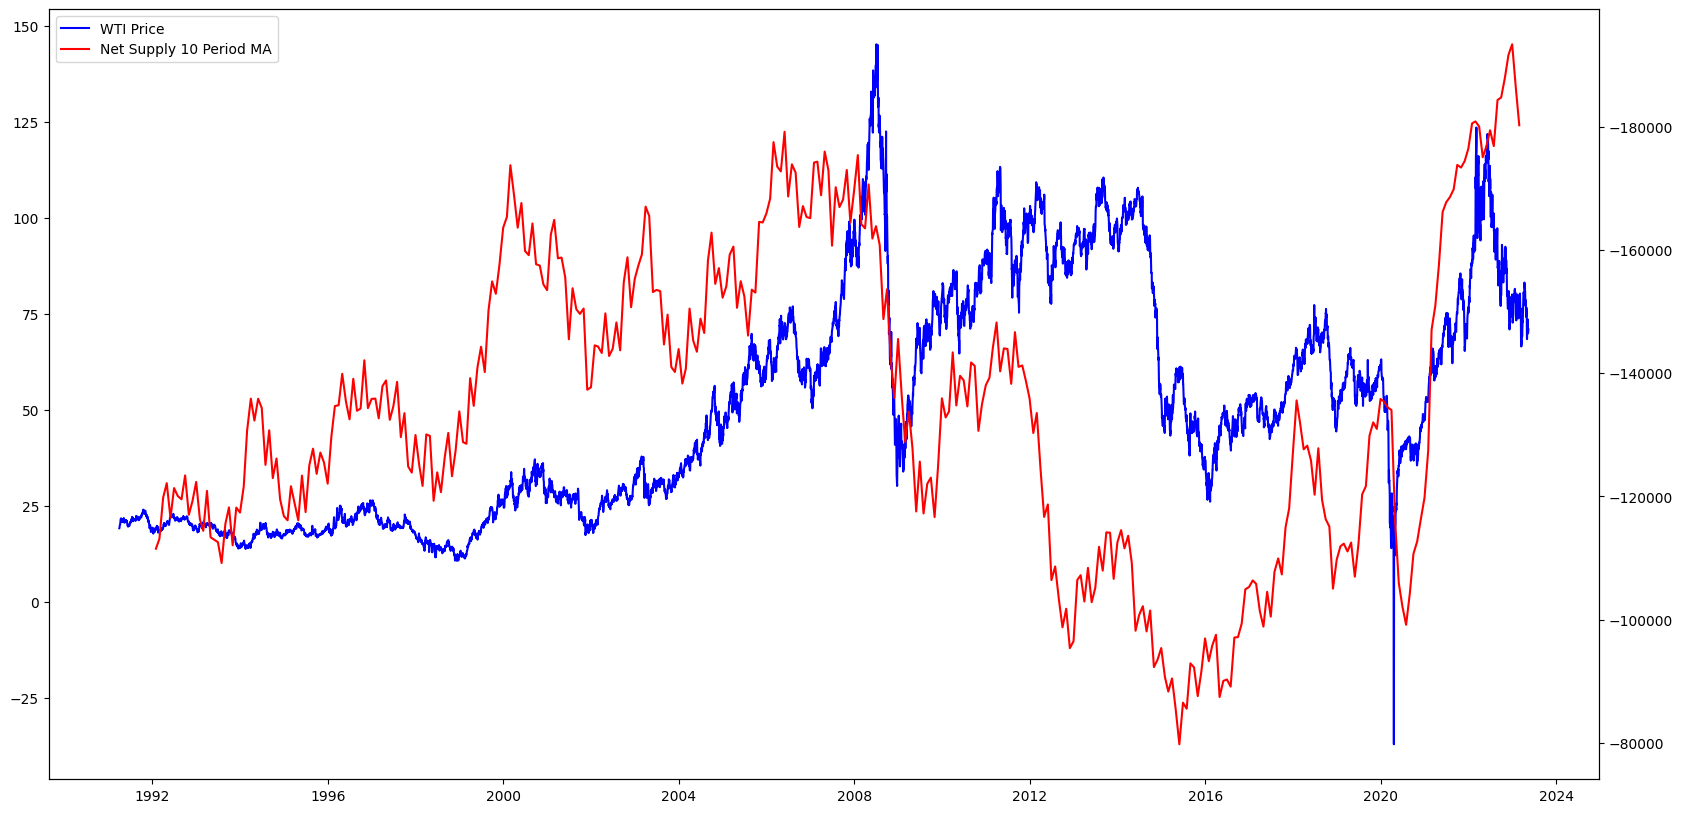

In [38]:
fig, ax = plt.subplots(figsize = (20,10))
ax2 = ax.twinx()
ax.plot(data["prices"], color = "blue", label = "WTI Price")
ax2.plot(net_supply_smoothed, color = "red", label = "Net Supply 10 Period MA")
ax2.invert_yaxis()
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

Text(0, 0.5, 'WTI Price Change %YoY')

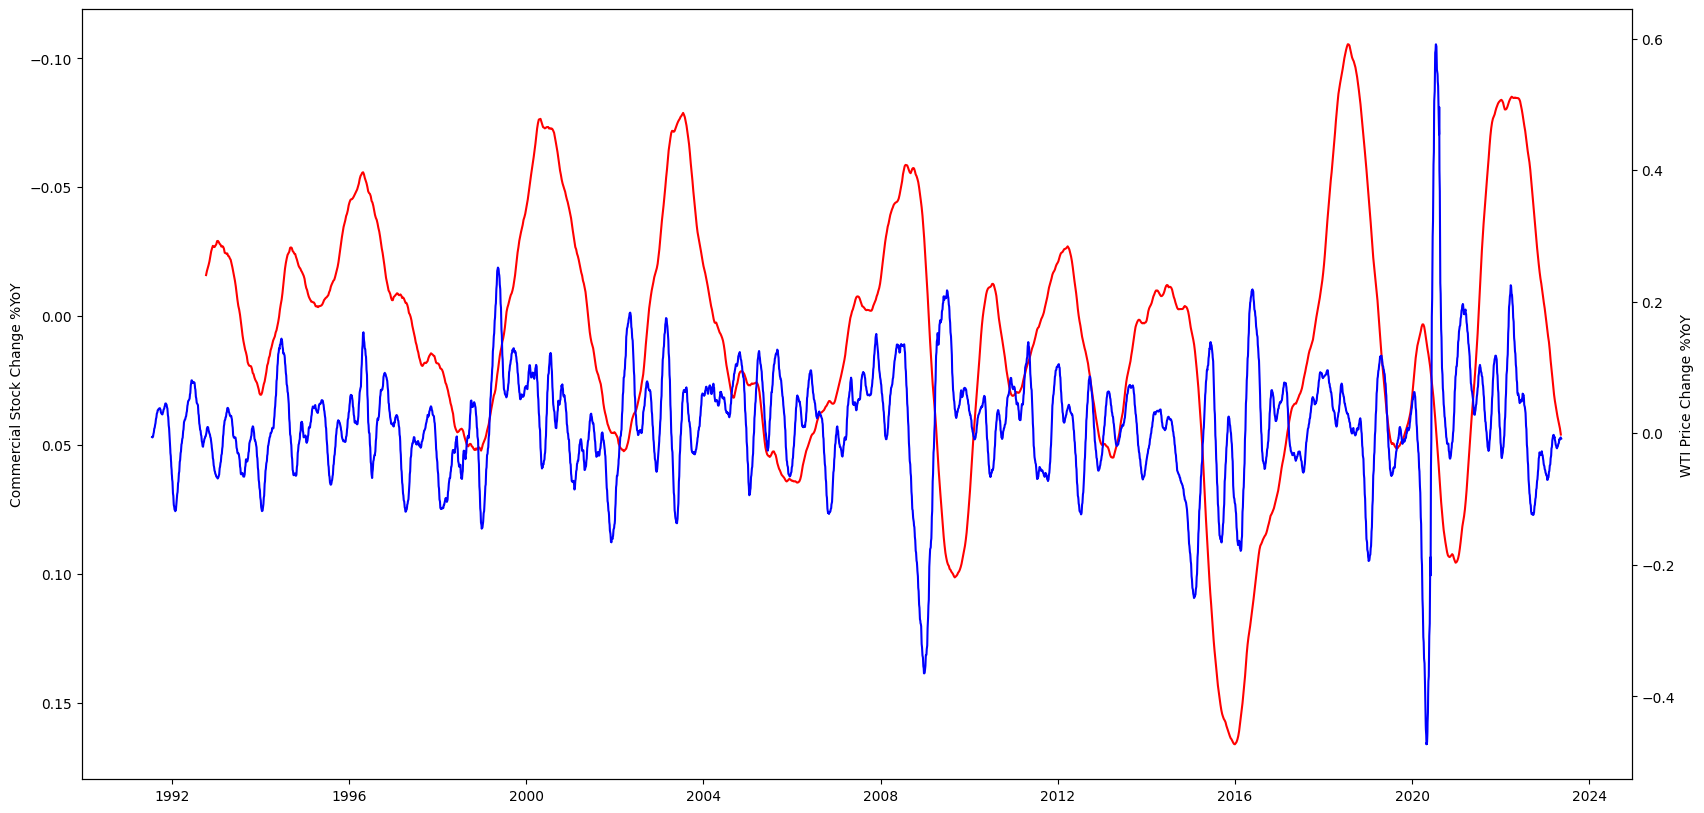

In [39]:
fig, ax = plt.subplots(figsize = (20,10))
ax2 = ax.twinx()
ax.plot(ta.MA(data["commercial_stock"].pct_change(30), 50), color = "red")
ax.invert_yaxis()
ax.set_ylabel("Commercial Stock Change %YoY")
ax2.plot(ta.MA(data["prices"].pct_change(30), 50), color = "blue")
ax2.set_ylabel("WTI Price Change %YoY")